In [1]:
import numpy as np
from matplotlib import pyplot
from IPython.display import clear_output
from time import sleep
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, UpSampling2D

2024-02-07 22:37:17.127264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 22:37:18.996432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 22:37:31.101521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


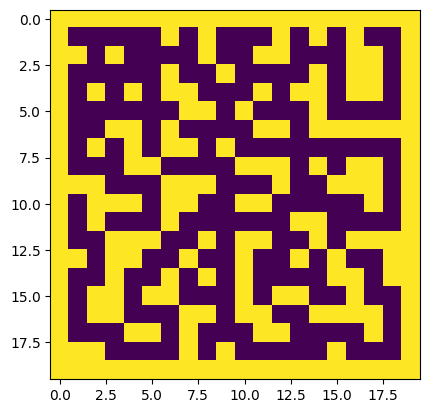

In [2]:
#maze generator, Wilson's algorithm,
#2-wall, 1-passage, 0 - unvisited

def maze_generator(size,show_steps=False,animate=False):
    maze=np.zeros((size,size))
    maze[[0,size-1]]+=2
    maze[1:size-1][:,[0,size-1]]+=2
    
    for i in range(1,size-1):#range(1,3):#
        for j in range(1,size-1):#range(1,3):#
            if i==1 and j==1:
                first=True
            else:
                first=False
            y,x=i,j
            if maze[y,x]!=0:
                continue
            else:
                path=[]
                wall=[]
                while(maze[y,x]!=2):
                    
                    path.append([x,y])
                    #print("path:",path)
                    #print("wall:",wall)
                    out_of_bounds=False
                    new_x,new_y=x,y
                    attempts=0
                    while((([new_x,new_y] in path) or ([new_x,new_y] in wall) or out_of_bounds==True)==True):
                        attempts+=1
                        #print("new x,y:",new_x,new_y)
                        #if [new_x,new_y] in path:
                        #    print("in path")
                        #if [new_x,new_y] in wall:
                        #    print("in wall")
                        #print("out of bounds:",out_of_bounds,"first:",first)
                        out_of_bounds=False    
                        if np.random.choice((-1,1))==1:
                            new_x=x+np.random.choice((-1,1))
                            new_y=y
                        else:
                            new_y=y+np.random.choice((-1,1))
                            new_x=x
                        if new_x==0 or new_x==(size-1) or new_y==0 or new_y==(size-1):
                            if first!=True:
                                out_of_bounds=True
                        if attempts>20:
                            x,y=path[0][0],path[0][1]
                            path=[[x,y]]
                            wall=[]
                            new_x,new_y=x,y
                            attempts=0
                    #append walls    
                    for k in range(-1,2):
                        for l in range(-1,2):
                            if (k!=0 and l!=0):
                                continue
                            if (k==new_x-x and x!=new_x) or (l==new_y-y and y!=new_y):
                                continue
                            else:
                                wall.append([x+k,y+l])
                                
                    #print("in while1")
                    #if is_wall==False:
                    x,y=new_x, new_y
                    #else:
                        #break
            
                #print("poza while")
                
                maze[[v[1] for v in wall],[v[0] for v in wall]]=2
                maze[[v[1] for v in path],[v[0] for v in path]]=1
                if (new_x==0 or new_x==(size-1) or new_y==0 or new_y==(size-1))==False:
                    maze[y,x]=1
                    for k in range(-1,2):
                        for l in range(-1,2):
                            if k!=0 and l!=0:
                                continue
                            if ((k==0 and l!=0) or (k!=0 and l==0)) and maze[y+l,x+k]==0:
                                maze[y+l,x+k]=2
                #if not(x==size-1 or x==0 or y==size-1 or y==0):
                    
                #print(path_x,path_y)
                #print(wall_x,wall_y)
                if show_steps==True:
                    if animate==True: 
                        clear_output(wait=True)
                    print_maze(maze)
    
    return maze

def print_maze(maze):
    fig=pyplot.figure()
    plot=fig.subplots()
    plot.imshow(maze)
    pyplot.show()
    
test_maze=maze_generator(20,True,True)
#print_maze(test_maze)


In [4]:
#function checking whether position pos belongs to the maze
def check(maze,pos):
    if maze[pos[0],pos[1]]==1:
        return True
    else:
        return False

#function placing treasures in the maze
def set_collectibles(maze,Ncol):
    size=len(maze)
    free_pos_list=[]
    for i in range(size):
        for j in range(size):
            if maze[i,j]==1 and (i!=1 and j!=1):
                free_pos_list.append([i,j])
    if Ncol>=len(free_pos_list):
        print("too many collectibles!")
    col_pos_list=np.random.choice(len(free_pos_list),Ncol,replace=False)
    return np.array([free_pos_list[i] for i in col_pos_list])

#visualization of agent's trajectory in the maze
def print_system(it,maze,collectibles,agent,fin_R,policy,directions):
    size=len(maze)
    col_x=collectibles[:,0]
    col_y=collectibles[:,1]
    agent_x=agent[:,0]
    agent_y=agent[:,1]
    N=len(agent)
    agent_color=[(i/N,i/N,i/N) for i in range(N)]
    
    fig=pyplot.figure(figsize=(15,5))
    plt=fig.add_gridspec(1,3)
    plot=plt.subplots()
    plot[0].imshow(maze)
    plot[0].scatter(agent_y,agent_x,color=agent_color)
    plot[0].scatter(col_y,col_x)
    plot[0].set_title(f"it={it:} <R>={fin_R[it]:.2}")

    plot[1].plot(fin_R[0:(it+1)])
    plot[1].set_title("mean return <R>")
    plot[1].set_xlabel("epoch")

    vec_field=np.transpose(policy[:,:,:,None]*directions,(1,0,2,3))
    
    vec_field_sum=vec_field.sum(2)
    x0,y0=np.meshgrid(np.arange(0,size),np.arange(0,size))
    #print(vec_field_sum[1])
    #print(policy[1])
    #print("x,y shape",np.shape(x0))
    #print("vec field shape:",np.shape(vec_field))
    plot[2].imshow(maze)
    plot[2].quiver(y0,x0,vec_field_sum[:,:,1],vec_field_sum[:,:,0],color='red')
    plot[2].set_title("policy: mean direction")
    clear_output(wait=True)
    pyplot.show()
    sleep(2)

#auxilary functions for simulation

def choose_move(policy):
    #print(np.shape(policy))
    a=np.random.random()
    sum_tab=np.cumsum(policy)
    for i in range(4):
        if a<sum_tab[i]:
            break
    return i

def params_delta(current_policy,action,R,eta):
    delta=np.array([1 if i==action else 0 for i in range(4)])
    return eta*R*(delta-current_policy)

def policy_fun(params):
    #print(np.shape(params))
    matrix=np.exp(params)
    return matrix/matrix.sum(2)[:,:,None]

#simulation of agent in the maze, deterministic improvement of movement policy (no NN)
def reinforced_learning_deterministic(map_size,Nbatch,Nmoves,Ncol,eta):
    move=np.array([[-1,0],[1,0],[0,-1],[0,1]])
    policy=np.full([Nbatch,map_size,map_size,4],0.25)
    policy_params=np.full([map_size,map_size,4],0.0)
    print(np.shape(policy))
    maze=maze_generator(map_size)
    col_pos=set_collectibles(maze,Ncol)
    #print(col_pos)
    pos=np.array([[[1,1]]*Nmoves]*Nbatch)
    print(np.shape(pos))

    fin_R=np.zeros(Nmoves)
    for it in range(Nbatch):
        R=0
        col_pos_tmp=np.zeros((map_size,map_size))
        for v in col_pos:
            col_pos_tmp[v[0],v[1]]=1.0
        action=np.array([0]*Nmoves)
        for n in range(1,Nmoves):
            print("it=",it,"n=",n,"R=",R,end="        \r")
            #choose correct move according to policy at this position
            action[n]=choose_move(policy[it,pos[it,n-1,0],pos[it,n-1,1]])
            new_pos=pos[it,n-1]+move[action[n]]
            if check(maze,new_pos)==True:
                    pos[it,n]=new_pos
            else:
                pos[it,n]=pos[it,n-1]
            #print("col_found:",col_found)
            if col_pos_tmp[pos[it,n,0],pos[it,n,1]]==1.0:
                R+=1
                col_pos_tmp[pos[it,n,0],pos[it,n,1]]-=1
        #print system
        fin_R[it]=R
        print_system(it,maze,col_pos,pos[it],fin_R,policy[it],move)
        #update policy
        if(it<Nbatch-1):
            policy[it+1]=policy[it].copy()
            for n in range(Nmoves):
                policy_params[pos[it,n,0],pos[it,n,1]]+=params_delta(policy[it,pos[it,n,0],pos[it,n,1]],action[n],R,eta)
            policy[it+1]=policy_fun(policy_params[:,:])
        #print(policy[it].sum())
                
    
#reinforced_learning_deterministic(20,10,10000,50,0.001)

#explaination of graphics
#left: maze and treasures positions, agent trajectory - grayscale dots (white - most recent, black - oldest)
#middle: return function
#right: policy, arrows show averge (most probable) direction of move at each position

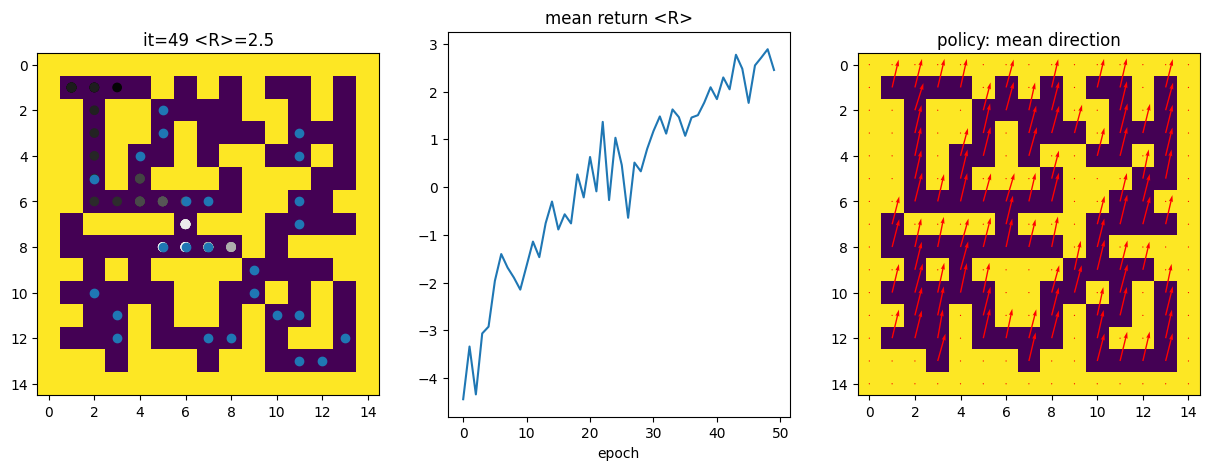

finished                      


In [5]:
def print_NN(tab_R,it):
    clear_output(wait=True)
    fig=pyplot.figure()
    plot=fig.subplots()
    plot.plot(tab_R)
    plot.set_title(f"it={it:} mean R={tab_R[len(tab_R)-1]:.2}")
    pyplot.show()

def reinforced_learning_NN(network,map_size,Nepoch,Nbatch,Nmoves,Ncol,Rcol,Rwall):
    move=np.array([[-1,0],[1,0],[0,-1],[0,1]])
    #policy_matrix only for visualization
    policy_matrix=np.full([Nepoch,map_size,map_size,4],0.25)
    #policy_params=np.full([map_size,map_size,4],0.0)
    #print(np.shape(policy))
    maze_for_plot=maze_generator(map_size)
    maze=-(maze_for_plot-2) #redefinig maze to be only 1 and 0
    col_pos=set_collectibles(maze,Ncol)
    #print(col_pos)
    

    cost=np.array([0.0]*Nepoch)
    mean_R=np.array([0.0]*Nepoch)
    fin_R=np.zeros((Nbatch,Nepoch))

    for it in range(Nepoch):
        R=np.array([0.0]*Nbatch)
        col_pos_tmp=np.zeros((Nbatch,Nmoves+1,map_size,map_size))
        for v in col_pos:
            col_pos_tmp[:,0,v[0],v[1]]=1.0

        pos=np.array([[[1,1]]*(Nmoves+1)]*Nbatch)
        
        #input for NN to predict policy
        input_data=np.zeros((Nbatch,map_size,map_size,3))
        input_data[:,:,:,0]=maze[:,:]
        input_data[:,:,:,1]=col_pos_tmp[:,0,:,:]
        input_data[:,1,1,2]=1.0 #initial position
        
        action=np.array([[0]*(Nmoves+1)]*Nbatch)
        
        for n in range(0,Nmoves):
            #print(n)
            #print(col_pos_tmp[0,0])
            
            input_data[:,:,:,1]=col_pos_tmp[:,n]
            
            for k in range(Nbatch):
                input_data[k,pos[k,n,0],pos[k,n,1],2]=1.0
            
            policy=network.predict_on_batch(input_data)
            
            print("it=",it,"n=",n,f"<R>={R.sum()/Nbatch:.2}",end="        \r")
            
            #choose correct move according to policy at this position
            rand_vec=np.random.random(Nbatch)
            policy_cumsum=np.cumsum(policy,1)
            for i in range(Nbatch):
                action[i,n]=np.searchsorted(policy_cumsum[i],rand_vec[i])#choose_move_vec(policy[it,pos[:,n-1,0],pos[:,n-1,1]],rand_vec[:])
            #print(action)
            new_pos=pos[:,n]+move[action[:,n]]
            is_pos_ok=np.array([check(maze,new_pos[i]) for i in range(Nbatch)])
            pos[:,n+1]=pos[:,n]+is_pos_ok[:,None]*move[action[:,n]]
            R[:]-=(1-is_pos_ok[:])*Rwall #penalties for hitting walls
            col_pos_tmp[:,n+1,:,:]=col_pos_tmp[:,n,:,:]

            for i in range(Nbatch):
                if col_pos_tmp[i,n,pos[i,n+1,0],pos[i,n+1,1]]==1.0:
                        R[i]+=Rcol
                        col_pos_tmp[i,n+1,pos[i,n+1,0],pos[i,n+1,1]]-=1.0
            """
            for i in range(Nbatch):
                if check(maze,new_pos[i])==True:
                    pos[i,n+1]=new_pos[i]
                    if col_pos_tmp[i,n,pos[i,n+1,0],pos[i,n+1,1]]==1.0:
                        R[i]+=5.0
                        col_pos_tmp[i,n+1,pos[i,n+1,0],pos[i,n+1,1]]-=1.0
                else:
                    pos[i,n+1]=pos[i,n]
                    R[i]-=0.1
            """
        fin_R[:,it]=R[:]

        #prepare policy_matrix for plotting
        input_pol_mat=np.zeros((map_size*map_size,map_size,map_size,3))
        input_pol_mat[:,:,:,0]=maze[:,:]
        input_pol_mat[:,:,:,1]=col_pos_tmp[0,0,:,:]
        idx=0;
        for i in range(map_size):
            for j in range(map_size):
                input_pol_mat[idx,i,j,2]=maze[i,j]
                idx+=1
        #print(input_pol_mat[20,:,:,2])
        policy_list=network.predict_on_batch(input_pol_mat)
        #print(policy_list)
        pol_mat_tmp=np.reshape(policy_list,(map_size,map_size,4))
        policy_matrix[it]=np.array([[policy_matrix[it,i,j] if maze[i,j]!=1 else pol_mat_tmp[i,j] for j in range(map_size)] for i in range(map_size)])
        #print(policy_matrix[it])
        
        #print system
        print_system(it,maze_for_plot,col_pos,pos[0],fin_R.sum(0)/Nbatch,policy_matrix[it],move)
        
        #update policy
        input_training_data=np.zeros((Nbatch*Nmoves,map_size,map_size,3))
        output_training_data=np.zeros((Nbatch*Nmoves,4))
        idx=0
        for i in range(Nbatch):
            for j in range(Nmoves):
                input_training_data[idx,:,:,0]=maze[:,:]
                input_training_data[idx,:,:,1]=col_pos_tmp[i,j,:,:]
                #input_training_data[idx,:,:,2]=np.zeros((map_size,map_size))
                input_training_data[idx,pos[i,j,0],pos[i,j,1],2]=1.0
                output_training_data[idx,action[i,j]]=fin_R[i,it]
                idx+=1
        #print(input_training_data[5,:,:,2])
        #print(output_training_data[4])
        print("training on batch...", end="          \r")
        cost[it]=network.train_on_batch(input_training_data,output_training_data)
        print("simulating...", end="                 \r")
        mean_R[it]=fin_R[:,it].sum()/Nbatch
        #if it>0:
        #    print_NN(mean_R[0:it],it)
    print("finished     ")

#define neural network here
map_size=15
network=Sequential()
#network.add(Dense(4,input_shape=(map_size,map_size,3),activation='relu'))
network.add(Conv2D(5,kernel_size=5,input_shape=(map_size,map_size,3),activation='elu',padding='same'))
network.add(Conv2D(5,kernel_size=5,input_shape=(map_size,map_size,3),activation='elu',padding='same'))
network.add(Conv2D(5,kernel_size=5,input_shape=(map_size,map_size,3),activation='elu',padding='same'))
network.add(Flatten())
network.add(Dense(4,activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(0.001))

#main function performing simulation and training, parameters:
# network - NN model, map_size - maze size, Nepoch - number of training events on batches, Nbatch - number of trajectories simulated
# simultaneously, Nmoves - how many moves agent makes in one trajectory, Ncol - number of treasures in a maze, 
# Rcol - return from finding treasure, Rwall - penalty for hitting wall 
reinforced_learning_NN(network,map_size,Nepoch=50,Nbatch=100,Nmoves=100,Ncol=25,Rcol=2.0,Rwall=0.1)
#explaination of graphics
#left: maze and treasures positions, exemplary agent trajectory from a batch - grayscale dots (white - most recent, black - oldest)
#middle: return function
#right: policy, arrows show polices predicted by NN for all positions in the maze 